## 3 task


In [5]:
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd

In [6]:
def var(rho, k):
    return (1 + rho**2)/k
def make_sigma(rho):
    return np.array([[1., rho], [rho, 1.]])
def sample(rho, k):
    r = make_sigma(rho)
    y = np.random.multivariate_normal([0., 0.], r , k)
    return y[..., 0], y[..., 1]
def T(x,y):
    return np.mean(x*y)

def bound(k, alpha= 0.05):
    return norm.ppf(1 - alpha/2, loc = 0., scale = (1./k)**0.5)
def criteria(statistics, k, alpha = 0.05):
    return abs(statistics) < bound(k, alpha)

def significance_level(T_seq, k):
    rez = 1- norm.cdf(abs(T_seq), loc = 0.,  scale = (1./k)**0.5) + \
            norm.cdf(-abs(T_seq), loc = 0.,  scale = (1./k)**0.5)
    return rez

lets check distribution

In [7]:
k = 100
rhos = [0., 0.5]
samples = defaultdict(lambda: [])
for rho, color in zip(rhos, ['black', 'green']):
    for i in range(40000):
        samples[rho].append(T(*sample(rho, k)))

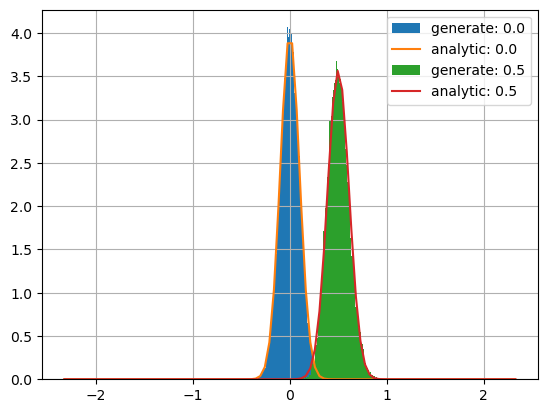

In [8]:
for rho in rhos:
    plt.hist(samples[rho], bins = 100, density=True, label= f'generate: {rho}')
    x = np.linspace(norm.ppf(0.01), norm.ppf(0.99), 100)
    plt.plot(x, norm.pdf(x, loc = rho, scale = np.sqrt(var(rho, k))  ) , label = f'analytic: {rho}')
plt.legend()
plt.grid()
plt.show()

In [9]:
rho = 0.2
stat = T(*sample(rho, k))
print(f"stat: {stat}, bound: {bound(k)}")
criteria(T(*sample(rho, k)), k)

stat: 0.16698742541390266, bound: 0.1959963984540054


True

зависимость мощности критерия от параметров

он не совсем хорош при малых значениях n так как используется грубое приближение

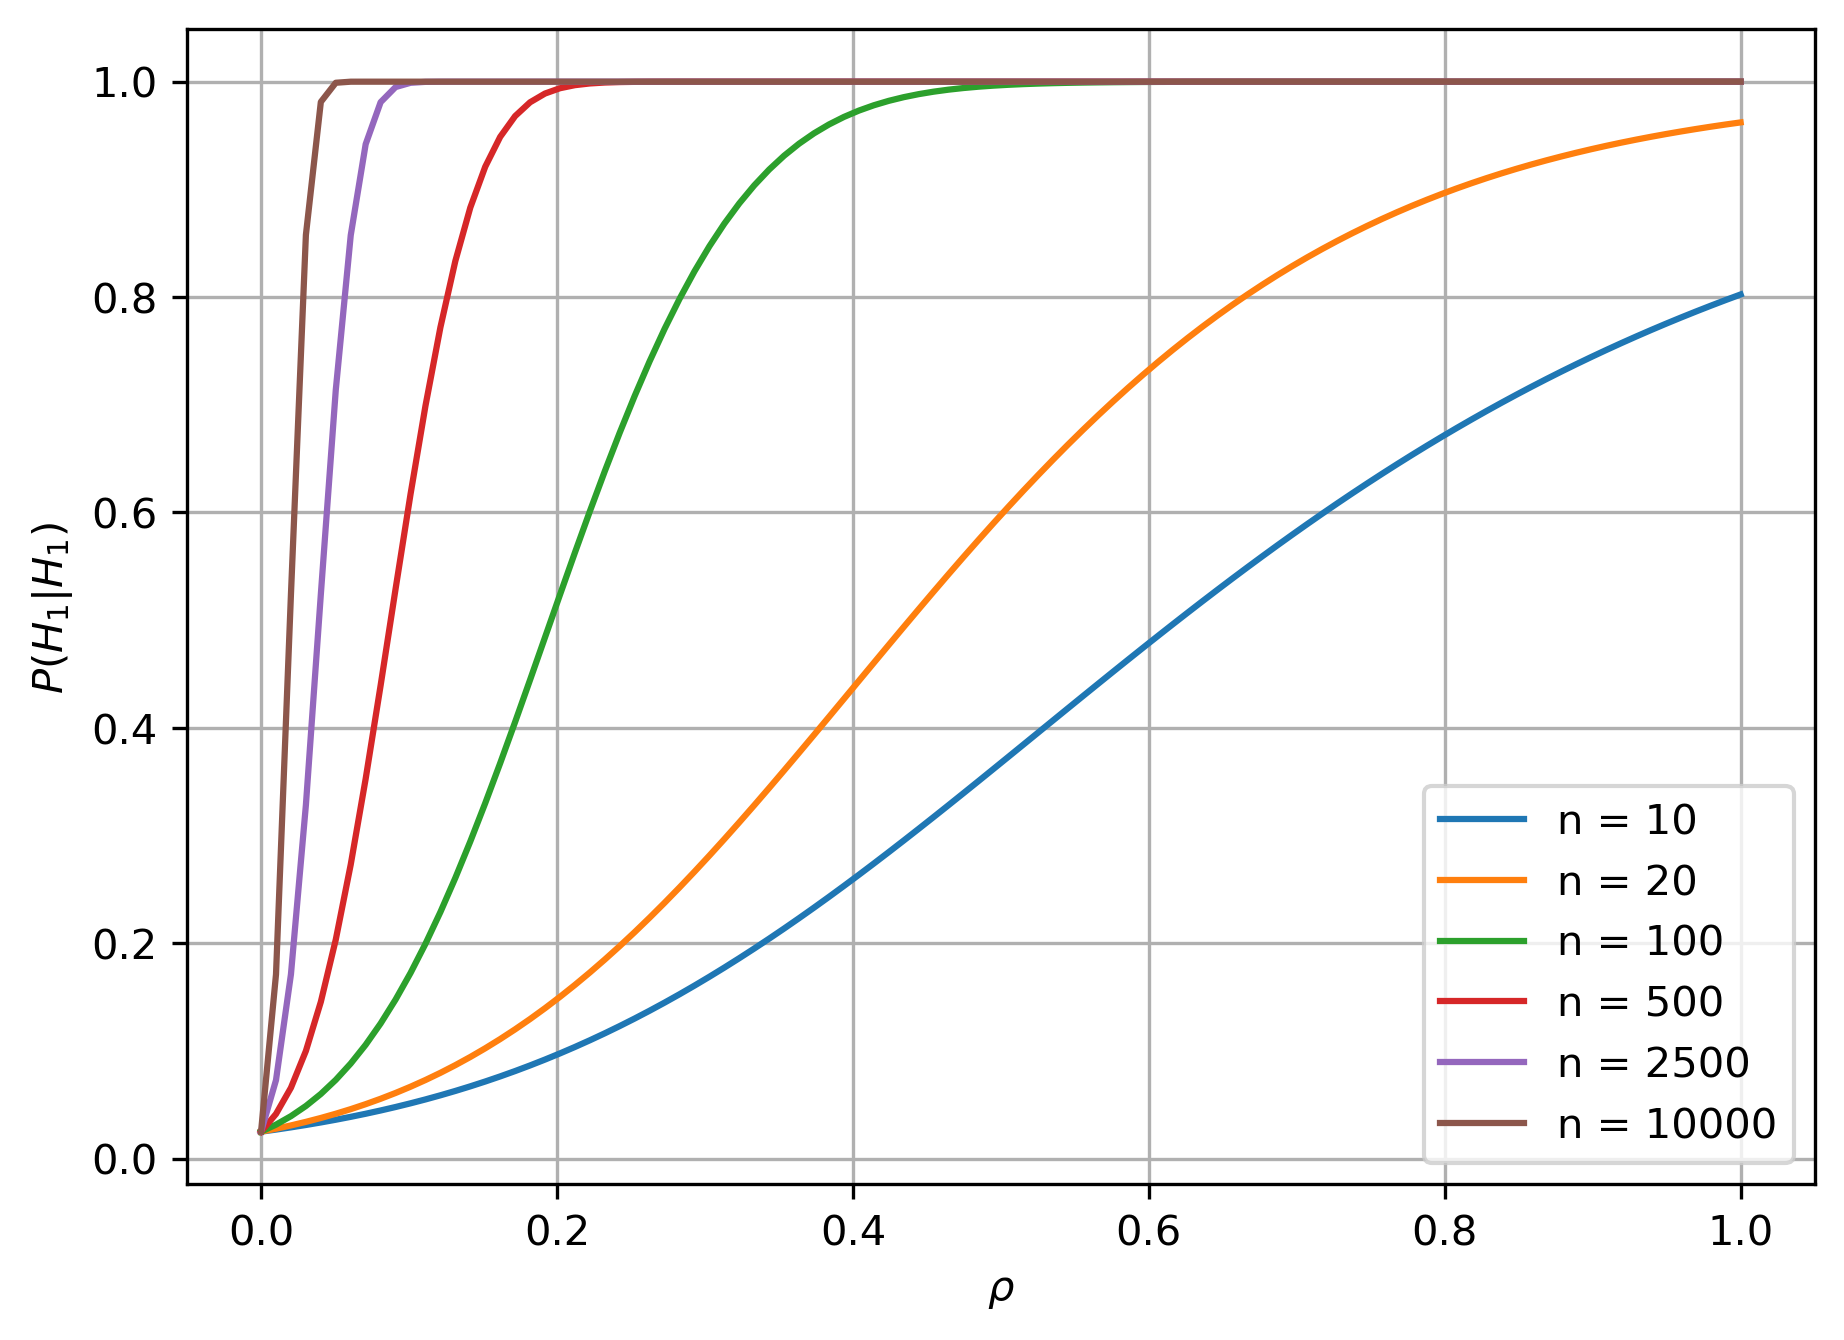

In [10]:
n = [10, 20, 100, 500, 2500, 10000]
rhos = np.linspace(0., 1., 100)
ax = plt.figure(figsize=(7, 5), dpi = 300)
for k in n:
    bound_ = bound(k)
    line = []
    for rho in rhos:
        line.append(1 - norm.cdf(bound_, loc = rho, scale = ((1 + rho**2)/k)**0.5))
    plt.plot(rhos, line, label = f"n = {k}")
plt.xlabel(r"$\rho$")
plt.ylabel(r"$P(H_1 | H_1)$")
plt.legend()
plt.grid()
plt.show()

график мощности критерия из семинара

![Alt text](image.png)

видно что критерий из семинара лучше работает при маленьких выборках. С другой стороны критерий, рассмотренный в задаче при больших n работает лучше

В задаче сказано оценить мощность критерия при семплированием. Сделаем это для $n = 100$. Для этого просто семплируем много выборок и смотрим долю для которых случилось отклонение

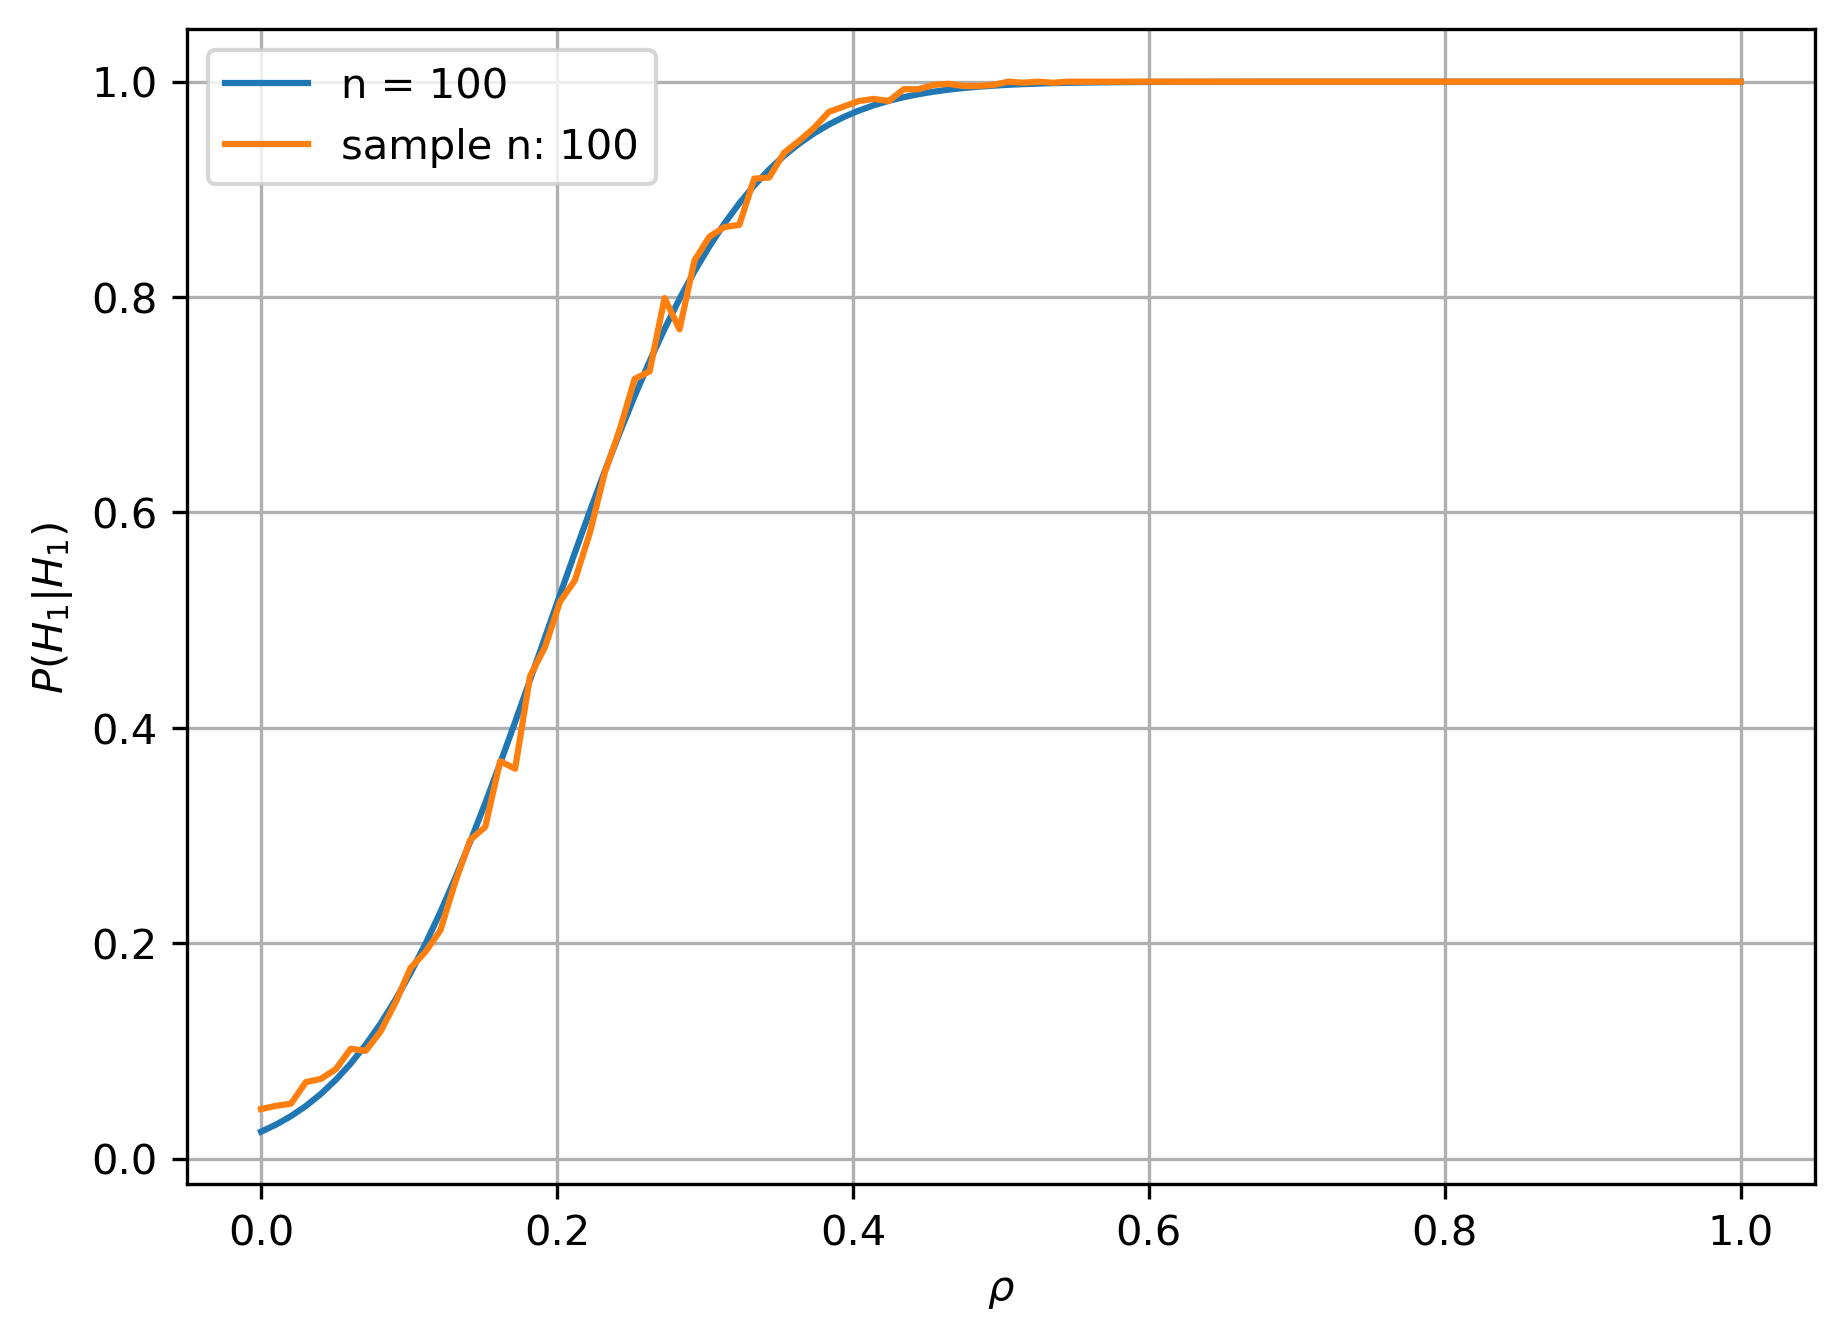

In [11]:
samples = 1000
k = 100
rhos = np.linspace(0., 1., 100)
ax = plt.figure(figsize=(7, 5), dpi = 300)

# true criteria power
line = []
bound_ = bound(k)
for rho in rhos:
    line.append(1 - norm.cdf(bound_, loc = rho, scale = ((1 + rho**2)/k)**0.5))
plt.plot(rhos, line, label = f"n = {k}")
# samples criteria power
line = []
for rho in rhos:
    accepts = 0.
    for _ in range(samples):
        accepts += criteria(T(*sample(rho, k)), k)
    line.append(1 - accepts/samples)
plt.plot(rhos, line, label = f"sample n: {k}")
plt.xlabel(r"$\rho$")
plt.ylabel(r"$P(H_1 | H_1)$")
plt.legend()
plt.grid()
plt.show()

Ура, получилось что-то похожее. При желании можно проделать для остальных $n$

На практике лучше применять статистику из семинара для небольших выборок n < 250, а для n >= 250 использовать статистику из задачи.

## № 4

график приближенно аналитического вывода

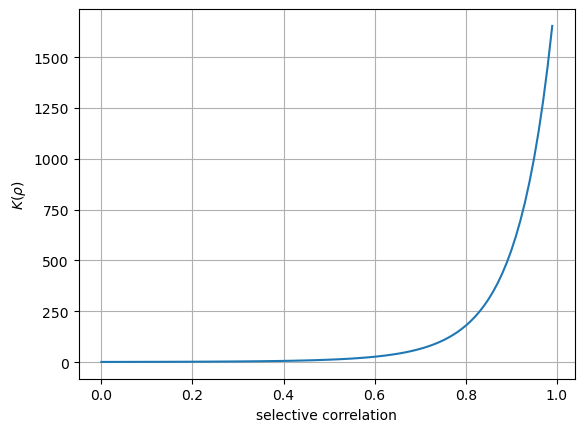

In [39]:
rhos = np.linspace(0., 0.99, 100)
x_s = []
n = 12
corr = 1./n
for rho in rhos:
    x_s.append(1/(1 - norm.cdf(rho, loc = 0., scale = corr**0.5) + norm.cdf(-rho, loc = 0., scale = corr**0.5)))
plt.plot(rhos, x_s, label = r"$K(\rho)$")
plt.grid()
plt.xlabel('selective correlation')
plt.ylabel(r"$K(\rho)$")
plt.show()


теперь рассмотрим семплирование. для Этого просто семплируем выборку и считаем корреляцию. После делаем plot hist

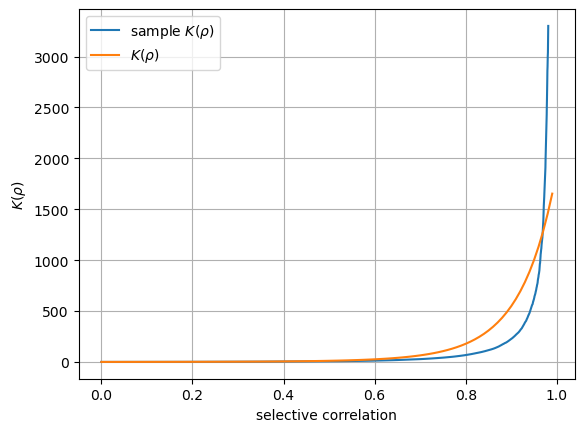

In [40]:
k = 500000
to = 150
n = 12
corrs = []
x = norm.rvs(size = (n))
for i in range(k):
    y = norm.rvs(size = (n))
    corr = np.mean(x*y)
    corrs.append(abs(corr))
np.sum(np.array(corrs) > 0.8)/k
corrs = sorted(corrs)
corrs = np.array(corrs)
corrs = corrs[(corrs <= 0.99)]
llen = len(corrs)
y_s = np.arange(1, llen + 1)[::-1] / llen
y_s = 1./ y_s
plt.plot(corrs[:-to], y_s[:-to], label = r"sample $K(\rho)$")
plt.plot(rhos, x_s, label = r"$K(\rho)$")
plt.grid()
plt.xlabel('selective correlation')
plt.ylabel(r"$K(\rho)$")
plt.legend()
plt.show()


можно видеть что теоритическая оценка и семплирование не сильно отличаются на корреляциях < 0.9. Для Большей корреляции оценки расходятся ввиду грубого теоретического приближения и редкости событий при семплировании.

Теоретическая оценка дает 1283 семплирований для достижения корреляции > 0.97, оценка семплированием дает 2756 семплирований. 

Полученные результаты показывают, что слишком большие корреляции хоть и не являются достаточным условием достаточности, но все же довольно редки. Если между величинами есть хорошая корреляция, то возможно они просто являютя следствием одного процесса. Например количество пожаров и потребление мороженного сильно скоррелированы и являются следствием жаркой погоды.


## № 5

чтобы наивный байесовский классификатор ошибался нужно, чтобы фичи были зависимы. Построим такой датасет. 

Всего будет 2 класса, и у каждого элемента по 2 целочисленные фичи $\in \{0,1,2,3,4\}$

У представителей 0 класса сумма фич будет равна 4, у представителей 1 класса -- 5. Итого все элементы и их классы представлены ниже

In [14]:
import pandas as pd
data = pd.DataFrame()
data['elems'] = [[0,4],[1,3],[2,2],[3,1],[4,0],[1,4],[2,3],[3,2],[4,1]]
data["classes"] = [0,0,0,0,0,1,1,1,1]
data

,elems,classes
0,"[0, 4]",0
1,"[1, 3]",0
2,"[2, 2]",0
3,"[3, 1]",0
4,"[4, 0]",0
5,"[1, 4]",1
6,"[2, 3]",1
7,"[3, 2]",1
8,"[4, 1]",1


Однако наивный байесовский классификатор относит все элементы к нулевому классу:

In [15]:
from sklearn.naive_bayes import CategoricalNB

import numpy as np

X = np.array([[0,4],[1,3],[2,2],[3,1],[4,0],[1,4],[2,3],[3,2],[4,1]])
y = np.array([0,0,0,0,0,1,1,1,1])
model = CategoricalNB()
model.fit(X, y)
print("predicted probabilities:")
print(model.predict_proba(X))
print('predicted classes:')
model.predict(X)

predicted probabilities:
[[0.66942149 0.33057851]
 [0.50310559 0.49689441]
 [0.50310559 0.49689441]
 [0.50310559 0.49689441]
 [0.66942149 0.33057851]
 [0.50310559 0.49689441]
 [0.50310559 0.49689441]
 [0.50310559 0.49689441]
 [0.50310559 0.49689441]]
predicted classes:


array([0, 0, 0, 0, 0, 0, 0, 0, 0])

## № 6

In [16]:
# significance_level описан выше
#  функции для поправок
def bonferroni(significance):
    m = len(significance)
    return np.minimum(1., m * significance)

def benjamin_hohberg(significance):
    keys = np.argsort(significance)
    significance_sorted = np.take(significance, keys)
    m = len(significance)
    factor = np.arange(1,m+1)/float(m)
    significance_sorted = significance_sorted/factor
    significance_sorted = np.minimum.accumulate(significance_sorted[::-1])[::-1]
    significance = significance_sorted[keys]
    return significance

def make_table(significance, m0, alpha):
    # делает табличку принятых и отвергнутых гипотез как на лекции
    # для первых m0 элементов предполагается выполнение нулевой гипотезы
    m = len(significance)
    U = significance[:m0]
    U = np.sum(U > alpha)
    V = m0 - U
    T = significance[m0:]
    T = np.sum(T > alpha)
    S = m - m0 - T
    table = np.array(
        [[U, T, m - V- S],
         [V, S, V + S],
         [m0, m-m0, m]]
    )
    rez = pd.DataFrame(table, index = [r"# принятых $H_0$",r"# отвергнутых $H_0$",r"Всего"],
                       columns= [r"# верных",r"# неверных",r"Всего"])
    return rez

теперь отсемплируем и получим уровни значимости

In [17]:
rhos = [0., 0.2]
iters = 500
k = 100
sample_significances = []
for rho in rhos:
    for i in range(iters):
        T_seq = T(*sample(rho, k))
        significance = significance_level(T_seq, k)
        sample_significances.append(significance)
sample_significances = np.array(sample_significances)

In [18]:
alpha = 0.05
print(make_table(sample_significances, iters, alpha))

                     # верных  # неверных  Всего
# принятых $H_0$          472         228    700
# отвергнутых $H_0$        28         272    300
Всего                     500         500   1000


In [19]:
print(make_table(bonferroni(sample_significances), iters, alpha))

                     # верных  # неверных  Всего
# принятых $H_0$          500         488    988
# отвергнутых $H_0$         0          12     12
Всего                     500         500   1000


видим что $V = 0$, то есть поправка работает

In [20]:
from statsmodels.stats.multitest import multipletests

print(make_table(benjamin_hohberg(sample_significances), iters, alpha))
_, pv, *_ = multipletests(sample_significances, alpha)
print(make_table(pv, iters, alpha))

                     # верных  # неверных  Всего
# принятых $H_0$          470         377    847
# отвергнутых $H_0$        30         123    153
Всего                     500         500   1000
                     # верных  # неверных  Всего
# принятых $H_0$          500         488    988
# отвергнутых $H_0$         0          12     12
Всего                     500         500   1000


Поправка не контролирует FDR на нужном уровне, видимо нет положительной корреляции

Теперь рассмотрим 1000 выборок только из нулевого распределния

In [21]:
rhos = [0.]
iters = 1000
k = 100
sample_significances = []
for rho in rhos:
    for i in range(iters):
        T_seq = T(*sample(rho, k))
        significance = significance_level(T_seq, k)
        sample_significances.append(significance)
sample_significances = np.array(sample_significances)

In [22]:
alpha = 0.05
print(make_table(sample_significances, iters, alpha))

                     # верных  # неверных  Всего
# принятых $H_0$          957           0    957
# отвергнутых $H_0$        43           0     43
Всего                    1000           0   1000


In [23]:
print(make_table(bonferroni(sample_significances), iters, alpha))

                     # верных  # неверных  Всего
# принятых $H_0$         1000           0   1000
# отвергнутых $H_0$         0           0      0
Всего                    1000           0   1000


In [24]:
print(make_table(benjamin_hohberg(sample_significances), iters, alpha))

                     # верных  # неверных  Всего
# принятых $H_0$         1000           0   1000
# отвергнутых $H_0$         0           0      0
Всего                    1000           0   1000


поправка работает, так как статистики независимы

## № 7

In [25]:
rhos = [0.] * iters
iters = 1000
k = 100
sample_significances = []
for i in range(iters):
    rho = rhos[i]
    T_seq = T(*sample(rho, k))
    significance = significance_level(T_seq, k)
    sample_significances.append(significance)
    if i < iters - 1:
        rhos[i+1] = np.random.choice([rho, 0.2 - rho], p = [0.3, 0.7])
sample_significances = np.array(sample_significances)
rhos = np.array(rhos)
sample_significances_ = np.zeros_like(sample_significances)
m = np.sum(rhos < 1e-5)
sample_significances_[:m] = sample_significances[rhos < 1e-5]
sample_significances_[m:] = sample_significances[rhos > 1e-5]
sample_significances = sample_significances_

In [26]:
alpha = 0.05
print(make_table(sample_significances, m, alpha))

                     # верных  # неверных  Всего
# принятых $H_0$          470         232    702
# отвергнутых $H_0$        23         275    298
Всего                     493         507   1000


In [27]:
print(make_table(bonferroni(sample_significances), m, alpha))

                     # верных  # неверных  Всего
# принятых $H_0$          491         487    978
# отвергнутых $H_0$         2          20     22
Всего                     493         507   1000


In [28]:
from statsmodels.stats.multitest import multipletests


_, pv, *_ = multipletests(sample_significances, alpha)
print(make_table(pv, m, alpha))

print(make_table(benjamin_hohberg(sample_significances), m, alpha))

                     # верных  # неверных  Всего
# принятых $H_0$          491         487    978
# отвергнутых $H_0$         2          20     22
Всего                     493         507   1000
                     # верных  # неверных  Всего
# принятых $H_0$          456         392    848
# отвергнутых $H_0$        37         115    152
Всего                     493         507   1000


In [29]:
from statsmodels.stats.multitest import multipletests
p_s = [0.2, 0.03, 0.025, 0.04, 0.3]
alpha = 0.05
_, pv, *_ = multipletests(p_s, alpha, method = 'fdr_bh')
pv

array([0.25      , 0.06666667, 0.06666667, 0.06666667, 0.3       ])

поправка бенджамина хохберга не работает. Потому что статистики получаются зависимыми

In [30]:
import numpy as np
from scipy.stats import chisquare

f_obs = np.array([9,20,14,8,11,10])  # observed (empirical) frequencies
n = f_obs.sum()  # sample size
p_0 = np.ones(len(f_obs)) / len(f_obs)  # uniform categorical distribution
f_exp = n * p_0  # expected frequencies
t, p_value = chisquare(f_obs, f_exp)  # chi-squared test
p_value


0.147286351300178

In [31]:
from scipy.stats  import chi2

chi2()

TypeError: _parse_args() missing 1 required positional argument: 'df'